In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd
import xarray as xr

from mmctools.coupling.domain import Domain
from mmctools.coupling.sowfa import BoundaryCoupling
from mmctools.wrf.ts import Toof  # for mapping WRF solution to domain boundaries
from mmctools.plotting import plot_timeheight

# WRF to OpenFOAM example
This starts with tslist output from an existing WRF simulation: https://github.com/a2e-mmc/WRF-setups/tree/master/SWiFT_20131108_GFS

**beginning of setup**

In [3]:
wrfstart = '2013-11-08 00:00'
wrfdir = '/projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS'
tsoutdir = 'towers' # within wrfdir

In [4]:
sowfastart = '2013-11-08 12:00:00'
sowfaend = '2013-11-09 12:00' # not used
sowfadir = '.'

In [5]:
# boundaryData output parameters
output_fields = {
    'U': ('u','v','w'),
    'T': 'theta',
}
output_format = {
    'binary': False,
    'gzip': True,
}
# output_dates = {
#     'dateref': wrfstart, # datetime at which simulation t=0
#     'datefrom': sowfastart, # output range start
#     'dateto': sowfaend, # output range end
# }
output_dates = {
    'dateref': sowfastart,
}
output_freq = '10min'

In [6]:
reflatlon = (33.61056, -102.05056)  # TTU tower

In [7]:
# grid of tsout locations to map from
selected_towers = [
    't0051', 't0062', 't0073',
    't0050', 't0061', 't0072',
    't0049', 't0060', 't0071',
]

**end of setup**
***
## Set up microscale domain

In [8]:
# sowfadom = Domain(
#     xmin=-2500, xmax=2500,
#     ymin=-2500, ymax=2500,
#     zmin=0, zmax=1000,
#     nx=500, ny=500, nz=100,
#     origin_latlon=reflatlon,
# )

from windtools.openfoam import InputFile  # for parsing setUp file
sowfa = InputFile(os.path.join(sowfadir,'setUp'))
sowfadom = Domain(
    xmin=sowfa['xMin'], xmax=sowfa['xMax'],
    ymin=sowfa['yMin'], ymax=sowfa['yMax'],
    zmin=sowfa['zMin'], zmax=sowfa['zMax'],
    nx=sowfa['nx'], ny=sowfa['ny'], nz=sowfa['nz'],
    origin_latlon=reflatlon,
)

print(sowfadom)

Grid extent (5 km x 5 km x 1 km):
  x : (-2500, 2500), dx=20
  y : (-2500, 2500), dy=20
  z : (0, 1000), dz=20
  mesh size : 3.125M cells


### - check cell centers
it's a very good idea to do this to make sure ICs are correct, otherwise the boundary data that are written out will be jumbled

Notes:
* need to call `writeCellCenters` after `blockMesh` but _before_ `renumberMesh`
* the utility should be compiled with `wmake` in your `${SOWFA_DIR}/applications/utilities/writeCellCenters`

In [9]:
cc_actual = pd.read_csv(os.path.join(sowfadir,'constant','cellCenters.csv')).values

In [10]:
# - should match up with actual polyMesh cell centers BEFORE renumberMesh
xg,yg,zg = np.meshgrid(sowfadom.xcc,sowfadom.ycc,sowfadom.zcc,indexing='ij')
xg = xg.ravel(order='F')
yg = yg.ravel(order='F')
zg = zg.ravel(order='F')
cc_expected = np.stack((xg,yg,zg),axis=1)

In [11]:
assert np.allclose(cc_actual, cc_expected)

## Process WRF TS output

In [12]:
%%time
toof = Toof(wrfdir, tsdir=tsoutdir, prefixes=selected_towers, starttime=wrfstart, targetdomain=sowfadom)

# CPU times: user 1min 45s, sys: 1min 55s, total: 3min 40s
# Wall time: 3min 46s

Read /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/namelist.input
  max_dom = 3
  dx,dy = 3000.0 3000.0
Calculating grid lat/lon
Calling combine_towers for /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/towers ...
  interpolating to z= [ 0.0 20.0 40.0 .. 980.0 1000.0 ]
restart: .
starting t0051.d03
starting t0062.d03
starting t0073.d03
starting t0050.d03
starting t0061.d03
starting t0072.d03
starting t0049.d03
starting t0060.d03
starting t0071.d03
... done reading ts outputs
CPU times: user 1min 45s, sys: 1min 55s, total: 3min 40s
Wall time: 3min 46s


Text(-102.07723090594922, 33.5896798762557, 'approx microscale domain')

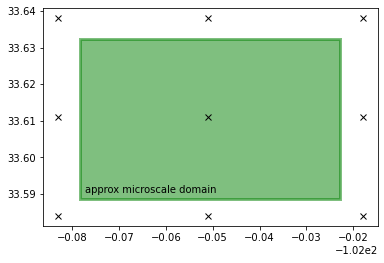

In [13]:
fig,ax = plt.subplots()
for lati,loni in zip(toof.ds.coords['lat'].values.ravel(), toof.ds.coords['lon'].values.ravel()):
    ax.plot(loni,lati,'kx')
xy0 = (sowfadom.lon[0,0], sowfadom.lat[0,0])
rect = mpatches.Rectangle(xy0, width=sowfadom.lon[-1,-1]-xy0[0], height=sowfadom.lat[-1,-1]-xy0[1],
                          color='g', alpha=0.5, lw=3)
ax.add_patch(rect)
ax.text(xy0[0]+.001,xy0[1]+.001,'approx microscale domain',
        horizontalalignment='left',verticalalignment='bottom')

In [14]:
assert toof.ds.coords['lat'].min() < sowfadom.lat[0,0]
assert toof.ds.coords['lat'].max() > sowfadom.lat[-1,-1]
assert toof.ds.coords['lon'].min() < sowfadom.lon[0,0]
assert toof.ds.coords['lon'].max() > sowfadom.lon[-1,-1]

### - check solution at reference location
this is _not_ used for the coupling

In [15]:
# get data column exactly at reference location
ref = toof.interp_to_latlon(reflatlon)

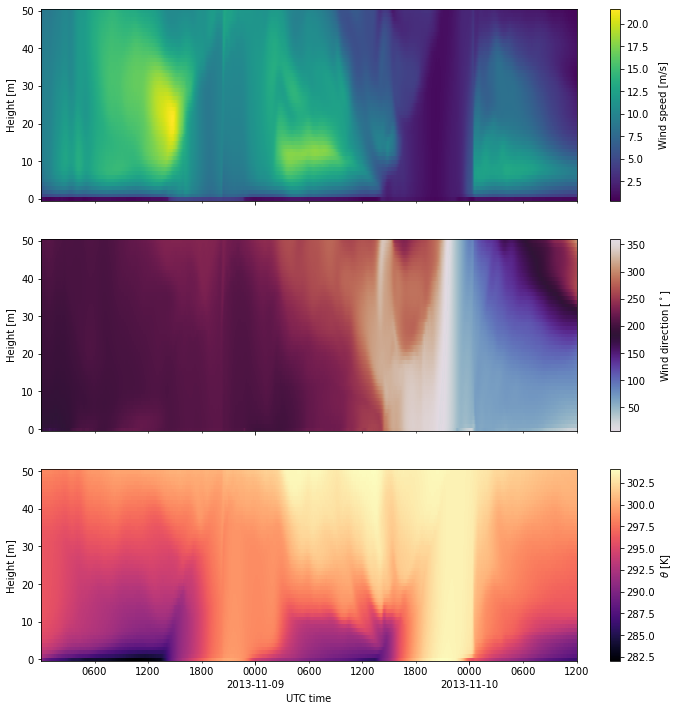

In [16]:
fig,ax,cb = plot_timeheight(ref, fields=['wspd','wdir','theta'], colorschemes={'theta':'magma'})

In [17]:
wdir = ref.sel(datetime=slice(sowfastart,sowfaend))['wdir']
wdir.to_pandas().describe().loc[['min','mean','max']]

height,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
min,197.897755,198.968620,199.758988,200.614555,201.020355,201.382543,201.624261,202.065020,202.545142,203.070873,...,212.276186,213.311642,214.910779,215.934537,216.938479,218.220656,218.617033,219.008836,220.758843,222.255296
mean,213.837173,212.837113,213.213449,213.556749,213.786101,213.955003,214.059436,214.114011,214.158888,214.285086,...,241.083960,241.896385,242.617348,243.326772,243.950535,244.541598,245.143282,245.706878,246.215607,246.737293
max,253.516579,252.964816,252.569411,252.364709,252.149782,251.702086,250.377995,248.317188,247.329878,248.735704,...,283.844077,281.981345,280.198939,278.434725,278.743641,279.269708,279.813686,280.376204,280.908373,281.461405


## Map WRF solution to microscale domain boundaries

In [18]:
%time lowerbc = toof.map_to_boundary(k=0)

selected lat: [33.58867988 33.63371848 33.58739647 33.63243289]
selected lon: [-102.07823091 -102.0767097  -102.02441791 -102.02286878]
interpolating to 0.0
CPU times: user 2.33 s, sys: 1.52 s, total: 3.85 s
Wall time: 3.86 s


In [19]:
%time upperbc = toof.map_to_boundary(k=-1)

selected lat: [33.58867988 33.63371848 33.58739647 33.63243289]
selected lon: [-102.07823091 -102.0767097  -102.02441791 -102.02286878]
interpolating to 1000.0
CPU times: user 2.23 s, sys: 1.47 s, total: 3.7 s
Wall time: 3.71 s


In [20]:
%time westbc = toof.map_to_boundary(i=0)

selected lat: [33.58867988 33.63371848]
selected lon: [-102.07823091 -102.0767097 ]
CPU times: user 941 ms, sys: 479 ms, total: 1.42 s
Wall time: 1.42 s


In [21]:
%time eastbc = toof.map_to_boundary(i=-1)

selected lat: [33.58739647 33.63243289]
selected lon: [-102.02441791 -102.02286878]
CPU times: user 880 ms, sys: 342 ms, total: 1.22 s
Wall time: 1.23 s


In [22]:
%time southbc = toof.map_to_boundary(j=0)

selected lat: [33.58867988 33.58739647]
selected lon: [-102.07823091 -102.02441791]
CPU times: user 909 ms, sys: 316 ms, total: 1.23 s
Wall time: 1.23 s


In [23]:
%time northbc = toof.map_to_boundary(j=-1)

selected lat: [33.63371848 33.63243289]
selected lon: [-102.0767097  -102.02286878]
CPU times: user 886 ms, sys: 362 ms, total: 1.25 s
Wall time: 1.25 s


## Write out boundaryData

In [24]:
outdir = os.path.join(sowfadir,'constant','boundaryData')

In [25]:
%%time
BoundaryCoupling(outdir,
    westbc.resample({'datetime':output_freq}).mean(),
    name='west',
    **output_dates
).write(output_fields, **output_format)

Input is an x-boundary at -2500
Wrote 102 points to ./constant/boundaryData/west/points
Skipping t= -43200.0
Skipping t= -42600.0
Skipping t= -42000.0
Skipping t= -41400.0
Skipping t= -40800.0
Skipping t= -40200.0
Skipping t= -39600.0
Skipping t= -39000.0
Skipping t= -38400.0
Skipping t= -37800.0
Skipping t= -37200.0
Skipping t= -36600.0
Skipping t= -36000.0
Skipping t= -35400.0
Skipping t= -34800.0
Skipping t= -34200.0
Skipping t= -33600.0
Skipping t= -33000.0
Skipping t= -32400.0
Skipping t= -31800.0
Skipping t= -31200.0
Skipping t= -30600.0
Skipping t= -30000.0
Skipping t= -29400.0
Skipping t= -28800.0
Skipping t= -28200.0
Skipping t= -27600.0
Skipping t= -27000.0
Skipping t= -26400.0
Skipping t= -25800.0
Skipping t= -25200.0
Skipping t= -24600.0
Skipping t= -24000.0
Skipping t= -23400.0
Skipping t= -22800.0
Skipping t= -22200.0
Skipping t= -21600.0
Skipping t= -21000.0
Skipping t= -20400.0
Skipping t= -19800.0
Skipping t= -19200.0
Skipping t= -18600.0
Skipping t= -18000.0
Skipping 

In [26]:
%%time
BoundaryCoupling(outdir,
    eastbc.resample({'datetime':output_freq}).mean(),
    name='east',
    **output_dates
).write(output_fields, **output_format)

Input is an x-boundary at 2500
Wrote 102 points to ./constant/boundaryData/east/points
Skipping t= -43200.0
Skipping t= -42600.0
Skipping t= -42000.0
Skipping t= -41400.0
Skipping t= -40800.0
Skipping t= -40200.0
Skipping t= -39600.0
Skipping t= -39000.0
Skipping t= -38400.0
Skipping t= -37800.0
Skipping t= -37200.0
Skipping t= -36600.0
Skipping t= -36000.0
Skipping t= -35400.0
Skipping t= -34800.0
Skipping t= -34200.0
Skipping t= -33600.0
Skipping t= -33000.0
Skipping t= -32400.0
Skipping t= -31800.0
Skipping t= -31200.0
Skipping t= -30600.0
Skipping t= -30000.0
Skipping t= -29400.0
Skipping t= -28800.0
Skipping t= -28200.0
Skipping t= -27600.0
Skipping t= -27000.0
Skipping t= -26400.0
Skipping t= -25800.0
Skipping t= -25200.0
Skipping t= -24600.0
Skipping t= -24000.0
Skipping t= -23400.0
Skipping t= -22800.0
Skipping t= -22200.0
Skipping t= -21600.0
Skipping t= -21000.0
Skipping t= -20400.0
Skipping t= -19800.0
Skipping t= -19200.0
Skipping t= -18600.0
Skipping t= -18000.0
Skipping t

In [27]:
%%time
BoundaryCoupling(outdir,
    southbc.resample({'datetime':output_freq}).mean(),
    name='south',
    **output_dates
).write(output_fields, **output_format)

Input is an y-boundary at -2500
Wrote 102 points to ./constant/boundaryData/south/points
Skipping t= -43200.0
Skipping t= -42600.0
Skipping t= -42000.0
Skipping t= -41400.0
Skipping t= -40800.0
Skipping t= -40200.0
Skipping t= -39600.0
Skipping t= -39000.0
Skipping t= -38400.0
Skipping t= -37800.0
Skipping t= -37200.0
Skipping t= -36600.0
Skipping t= -36000.0
Skipping t= -35400.0
Skipping t= -34800.0
Skipping t= -34200.0
Skipping t= -33600.0
Skipping t= -33000.0
Skipping t= -32400.0
Skipping t= -31800.0
Skipping t= -31200.0
Skipping t= -30600.0
Skipping t= -30000.0
Skipping t= -29400.0
Skipping t= -28800.0
Skipping t= -28200.0
Skipping t= -27600.0
Skipping t= -27000.0
Skipping t= -26400.0
Skipping t= -25800.0
Skipping t= -25200.0
Skipping t= -24600.0
Skipping t= -24000.0
Skipping t= -23400.0
Skipping t= -22800.0
Skipping t= -22200.0
Skipping t= -21600.0
Skipping t= -21000.0
Skipping t= -20400.0
Skipping t= -19800.0
Skipping t= -19200.0
Skipping t= -18600.0
Skipping t= -18000.0
Skipping

In [28]:
%%time
BoundaryCoupling(outdir,
    northbc.resample({'datetime':output_freq}).mean(),
    name='north',
    **output_dates
).write(output_fields, **output_format)

Input is an y-boundary at 2500
Wrote 102 points to ./constant/boundaryData/north/points
Skipping t= -43200.0
Skipping t= -42600.0
Skipping t= -42000.0
Skipping t= -41400.0
Skipping t= -40800.0
Skipping t= -40200.0
Skipping t= -39600.0
Skipping t= -39000.0
Skipping t= -38400.0
Skipping t= -37800.0
Skipping t= -37200.0
Skipping t= -36600.0
Skipping t= -36000.0
Skipping t= -35400.0
Skipping t= -34800.0
Skipping t= -34200.0
Skipping t= -33600.0
Skipping t= -33000.0
Skipping t= -32400.0
Skipping t= -31800.0
Skipping t= -31200.0
Skipping t= -30600.0
Skipping t= -30000.0
Skipping t= -29400.0
Skipping t= -28800.0
Skipping t= -28200.0
Skipping t= -27600.0
Skipping t= -27000.0
Skipping t= -26400.0
Skipping t= -25800.0
Skipping t= -25200.0
Skipping t= -24600.0
Skipping t= -24000.0
Skipping t= -23400.0
Skipping t= -22800.0
Skipping t= -22200.0
Skipping t= -21600.0
Skipping t= -21000.0
Skipping t= -20400.0
Skipping t= -19800.0
Skipping t= -19200.0
Skipping t= -18600.0
Skipping t= -18000.0
Skipping 

## Write out initial conditions

In [29]:
%time internalField = toof.map_to_internal_field(datetime=sowfastart)
# CPU times: user 4.76 s, sys: 444 ms, total: 5.21 s
# Wall time: 5.22 s

CPU times: user 11.9 s, sys: 3.17 s, total: 15.1 s
Wall time: 15.2 s


In [30]:
ds = internalField[['u','v','w','theta']].transpose('x','y','height')
u = ds['u'].values.ravel(order='F')
v = ds['v'].values.ravel(order='F')
w = ds['w'].values.ravel(order='F')
T = ds['theta'].values.ravel(order='F')

In [31]:
%%time
with open(os.path.join(sowfadir,'U0'), 'w') as f:
    f.write('internalField nonuniform List<vector>\n')
    f.write('{:d}\n'.format(len(u)))
    f.write('(\n')
    for ui,vi,wi in zip(u,v,w):
        f.write('({:g} {:g} {:g})\n'.format(ui,vi,wi))
    f.write(')\n;\n')
    
with open(os.path.join(sowfadir,'T0'), 'w') as f:
    f.write('internalField nonuniform List<scalar>\n')
    f.write('{:d}\n'.format(len(T)))
    f.write('(\n')
    for Ti in T:
        f.write('{:g}\n'.format(Ti))
    f.write(')\n;\n')
    

CPU times: user 7.78 s, sys: 51.9 ms, total: 7.83 s
Wall time: 7.85 s
